# Test different metrics of surprise for framework paper

### set a measure of potential for inputs
 - for each road segment that is blocked calculate the potential as the capacity (lanes * speed)

In [87]:
from concurrent.futures import ThreadPoolExecutor
import sqlite3
import pickle
import pandas as pd
import json
import xml.etree.ElementTree as ET
import numpy as np

# Read in data methods for both fleet and ladris

In [88]:
def read_fleet_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()   
    print("Length of rows: ", len(rows)) 
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inIDS, output_90, output_100, odist]

        d = tmpDat
        scen = {}
            
        #try:
        #    root = d[2].getroot()
        #except:
        #    print('error')
        #    root = []
        #    continue
        scenID = d[0]
        #print(root.tag)
        #for child in root:    
        #    ### find the segment ID
        #    segmentID = child.find('ID').text
        #    speed = float(child.find('Freeflow_Speed').text)
        #    lanes = float(child.find('Number_of_Lanes').text)
        #    blocked = False
        #    if segmentID in link_ids:
        #        scen[segmentID] = speed
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

def read_ladris_from_db(query):
    dat = {}
    conn = sqlite3.connect(dbFile)
    c = conn.cursor()
    c.execute(query)
    rows = c.fetchall()    
    for row in rows:
        ID = row[0]
        response = row[1]
        input = row[2]
        output_90 = row[3]
        output_100 = row[4]
        output_dist = row[5]

        inIDS = pickle.loads(input)
        odist = pickle.loads(output_dist)
        inXML = pickle.loads(input)

        tmpDat = [ID, response, inXML, output_90, output_100, odist]

        d = tmpDat
        scen = {}

        scenID = d[0]
        #print(root.tag)
        #for child in d[2]:    
        #    ### find the segment ID
        #    segmentID = child['osmid']
        #    speed = float(child['speed_mph'])
        #    lanes = float(child['num_lanes'])
        #    blocked = child['is_blocked']
        #    if blocked == True:
        #        scen[segmentID] = 1
        #    #if segmentID in link_ids:
        #        #scen[segmentID] = blocked
        saveDat = [inIDS, d[3]]  
        dat[ID] = saveDat#.append([ID, response, inXML, output_90, output_100, odist])

    conn.close()
    return dat

In [116]:
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile = 'lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'
comb_scenarios = {}


# Specify the Queries for read data methods

In [117]:
queries = [
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 2000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 4000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 2000 offset 6000',
    'SELECT * FROM scenarios ORDER BY id DESC limit 1000 offset 8000',    
]

#dbFile = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
with ThreadPoolExecutor(max_workers=6) as executor:
    ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
    if 'fleet' in dbFile:
        for result in executor.map(read_fleet_from_db, queries):
            comb_scenarios.update(result)        
    else:
        for result in executor.map(read_ladris_from_db, queries):
            comb_scenarios.update(result)    

print(len(comb_scenarios))

Length of rows: Length of rows:  0
Length of rows:  0
 0
Length of rows:  0
Length of rows:  2000
2000


In [118]:

### get the last value for key key value pair
results = []
for key, value in comb_scenarios.items():
    ### check if value is na or nonetype
    if value is None or pd.isna(value[-1]):
        results.append(np.nan)
    else:
        ### append the last value of the list
        if isinstance(value[-1], list):
            results.append(value[-1][-1])
        else:
            results.append(value[-1])
print(len(results))    

2000


In [121]:
### print unique values of results
unique_results = set(results)
print(len(unique_results))
#print("Unique results: ", unique_results)
### calculate the variance of the results
variance = np.var(results)
print("Variance of results: ", variance)

4
Variance of results:  8365005.697500001


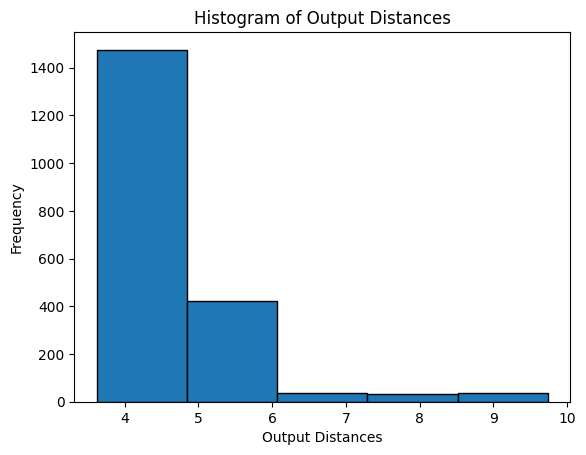

In [103]:
### plot histogram of results
import matplotlib.pyplot as plt
plt.hist(results, bins=5, edgecolor='black')
plt.xlabel('Output Distances')
plt.ylabel('Frequency')
plt.title('Histogram of Output Distances')
plt.show()

In [64]:
### measure entropy of results
from scipy.stats import entropy
results = np.array(results)
results = results[~np.isnan(results)]  # Remove NaN values
if len(results) > 0:
    hist, _ = np.histogram(results, bins=10, density=True)
    hist = hist[hist > 0]  # Remove zero entries for entropy calculation
    ent = entropy(hist)
    print(f'Entropy of results: {ent}')

Entropy of results: 1.3745064576380837


# Code to read in multiple database files and join the dataset for analysis

In [ ]:
### join 3 sqlite database files
#dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/guid_blocked_ladris_scenarios.db'
#dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv1.db'
#dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/ladris_scenarios_conv2.db'

dbFile1 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_roadBlocked_scenarios.db'
dbFile2 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv1.db'
dbFile3 = '/home/pfoytik/rtepm/EMA/lhc_samples/fleet_scenarios_conv2.db'
dbFiles = [dbFile2, dbFile3]
comb_scenarios = {}
scenCount = 0
for dbFile in dbFiles:
    with ThreadPoolExecutor(max_workers=6) as executor:
        ### if db file has fleet use function read_fleet_from_db else use read_ladris_from_db
        if 'fleet' in dbFile:
            for result in executor.map(read_fleet_from_db, queries):
                comb_scenarios.update(result)        
        else:
            for result in executor.map(read_ladris_from_db, queries):
                for key, value in result.items():
                    if key in comb_scenarios:
                        new_key = scenCount + int(key)
                        scenCount += 1
                        comb_scenarios[new_key] = value
                    else:
                        comb_scenarios[key] = value 
print(len(comb_scenarios))

3980


# Get Ladris Roads
- process the Ladris road network (JSON)
- read road data
- store id, geometry, number lanes, speed, length, and calculate potential
- Potential is measured as Lanes * Speed !!!removed length!!!

In [65]:
roadFile = '../lhc_samples/data/ladris/C27F9DE4CE6780696685FB4A4E31E242_orig'
with open(roadFile, 'r') as f:
    data = json.load(f)

ladris_latlong_dict = {}
ladris_potential_dict = {}
modified_dict = {}
ladris_segment_roadNames = {}

for i in data:
    #print(i)
    ladris_latlong_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['geometry']
    ladris_segment_roadNames[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = i['name']
    lanes = i['num_lanes']
    speed = i['speed_mph']
    ### convert speed to m/s
    speed = speed * 0.44704
    length = i['length_meters']    
    ladris_potential_dict[i['AC91D0B60F78BEFB85DE39CD9C3D2623']] = lanes * speed# * length

In [66]:
ladris_potential_dict[335090]

21.45792

# Get Fleet Roads
- process the fleet road network (XML)
- read road data
- store id, geometry, number lanes, speed, length, and calculate potential
- Potential is measured as Lanes * Speed !!!removed length!!!

In [67]:
### read segment id's from ../lhc_samples/data/fleet/segments.xml
tree = ET.parse('../lhc_samples/data/fleet/segments.xml')
root = tree.getroot()

fleet_segment_dict = {}
fleet_potential_dict = {}
fleet_segment_roadNames = {}
for child in root:
    fleet_segment_dict[child.find('ID').text] = child.find('Link_ID').text
    lanes = int(child.find('Number_of_Lanes').text)
    speed = int(child.find('Freeflow_Speed').text)

    fleet_potential_dict[child.find('ID').text] = lanes * speed

### read ../lhcsamples/data/fleet/links.xml
tree = ET.parse('../lhc_samples/data/fleet/links.xml')
root = tree.getroot()

fleet_link_dict = {}
fleet_name_dict = {}
for child in root:
    fleet_link_dict[child.find('ID').text] = [child.find('ANode').text, child.find('BNode').text]    
    fleet_name_dict[child.find('ID').text] = child.find('Name').text
    fleet_segment_roadNames[child.find('ID').text] = child.find('Name').text

### read ../lhcsamples/data/fleet/nodes.xml and get lat long for BNode of each fleet_link_dict
tree = ET.parse('../lhc_samples/data/fleet/nodes.xml')
root = tree.getroot()

fleet_node_dict = {}
for child in root:
    fleet_node_dict[child.find('ID').text] = [child.find('Latitude').text, child.find('Longitude').text]

fleet_lat_long_dict = {}
### for each segment in fleet_segment_dict, get the link_id, from fleet_link_dict get the BNode, from fleet_node_dict get the lat long
for segment in fleet_segment_dict:
    link_id = fleet_segment_dict[segment]
    anode = fleet_link_dict[link_id][0]
    bnode = fleet_link_dict[link_id][1]
    lat_long = [fleet_node_dict[anode], fleet_node_dict[bnode]]
    fleet_lat_long_dict[int(segment)] = [[float(lat_long[0][1]), float(lat_long[0][0])],[float(lat_long[1][1]), float(lat_long[1][0])]]

In [68]:
df_results = pd.DataFrame([x[1] for x in comb_scenarios.values()])

dataDict = {}
for k in comb_scenarios.keys():
    for link in comb_scenarios[k][0]:        
        if link in dataDict.keys():
            pass
        else:
            #if link in link_ids:
            dataDict[link] = []   

for k in comb_scenarios.keys():
    for i in dataDict.keys():
        if i in comb_scenarios[k][0]:
            #if link in link_ids:
            dataDict[i].append(1)
        else:
            #if link in link_ids:
            dataDict[i].append(0) 

df = pd.DataFrame(dataDict)



In [69]:
if 'ladris' in dbFile:
    df_results['minutes'] = df_results[0] * 60
    df_results['hours'] = df_results[0]
else:
    ### create a new column for the df_results called minutes that is equal to df_results[0] / 60
    df_results['minutes'] = df_results[0] / 60
    ### create a new column for df_results called hours that is equal to df_results[0] / 3600
    df_results['hours'] = df_results[0] / 3600

df_results.describe()

,0,minutes,hours
count,8998.000000,8998.000000,8998.000000
mean,4.110287,246.617192,4.110287
std,1.742195,104.531681,1.742195
min,0.000000,0.000000,0.000000
25%,3.948825,236.929513,3.948825
50%,4.389533,263.372010,4.389533
75%,4.998629,299.917721,4.998629
max,10.857103,651.426167,10.857103


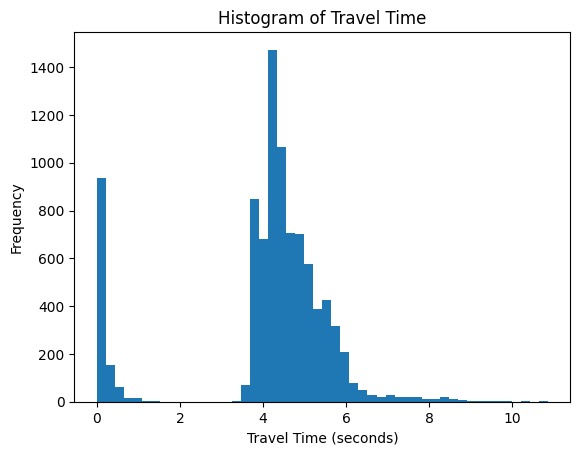

In [70]:
### Plot histogram of df_results
import matplotlib.pyplot as plt
plt.hist(df_results['hours'], bins=50)
plt.xlabel('Travel Time (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()

In [71]:
df_results['hours']

0       4.183883
1       4.321939
2       4.791880
3       4.189669
4       4.973522
          ...   
8993    3.600986
8994    3.848572
8995    3.790810
8996    3.709071
8997    0.000000
Name: hours, Length: 8998, dtype: float64

In [72]:

### get indexs of df_results for df_results['hours'] >= 6.5
idx = df_results[df_results['hours'] >= 4].index
### get indexs of df_results for df_results['hours'] < 6.5
idx2 = df_results[df_results['hours'] < 4].index

### describe df_results for the indexs of idx
df_results.loc[idx].describe()

,0,minutes,hours
count,6592.000000,6592.000000,6592.000000
mean,4.883307,292.998432,4.883307
std,0.788760,47.325622,0.788760
min,4.000137,240.008193,4.000137
25%,4.310717,258.642997,4.310717
50%,4.671702,280.302130,4.671702
75%,5.228634,313.718050,5.228634
max,10.857103,651.426167,10.857103


In [73]:
experiments = df
lowExperiments = experiments.loc[idx2]
highExperiments = experiments.loc[idx]
### Create outcomes as an array of df_results
outcomes = list(df_results['hours'].values)
lowOutcomes = list(df_results.loc[idx2]['hours'].values)
highOutcomes = list(df_results.loc[idx]['hours'].values)

In [74]:
### describe highOutcomes
pd.Series(highOutcomes).describe()

count    6592.000000
mean        4.883307
std         0.788760
min         4.000137
25%         4.310717
50%         4.671702
75%         5.228634
max        10.857103
dtype: float64

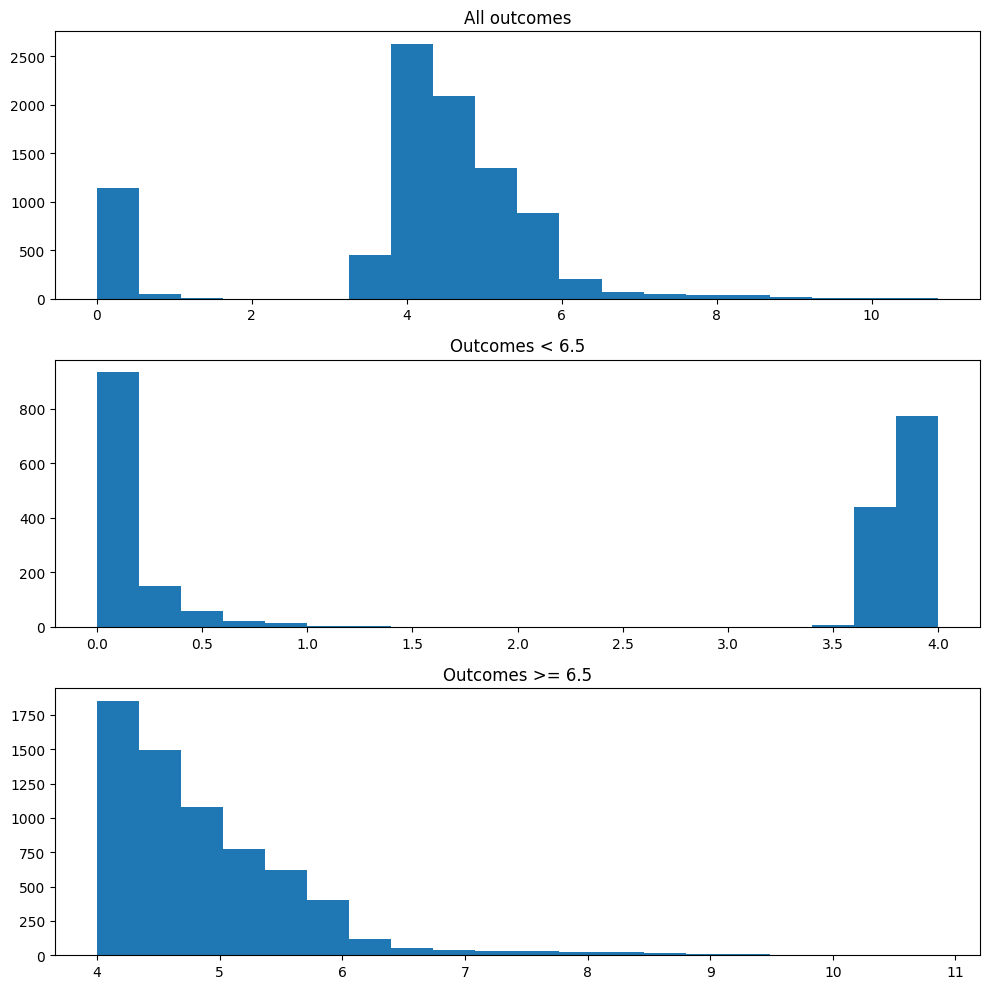

In [75]:
import matplotlib.pyplot as plt

### create three subplots of the outcomes
fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].hist(outcomes, bins=20)
ax[0].set_title('All outcomes')
ax[1].hist(lowOutcomes, bins=20)
ax[1].set_title('Outcomes < 6.5')
ax[2].hist(highOutcomes, bins=20)
ax[2].set_title('Outcomes >= 6.5')
plt.tight_layout()
plt.show()


# The list of segments that are associated with High critical evacuation times and are low on potential 0.5 lam1, 1.0 lam2
## Ladris Critical Segments
![image.png](images/ladris_critical_segments_2025-05-23.png)
## Ladris Critical and Low Potential (CSI)
![image.png](images/ladris_CSI_segments_2025-05-28.png)
## Fleet Critical Segments
![image.png](images/fleet_critical_segments.png)
## Fleet Critical and Low Potential (CSI)
![image-2.png](images/fleet_CSI_segments.png)



# Custom surprising critical measure
$$
Z=λ_1 × EvacuationTime − λ_2 × ScenarioPotential
$$
- Evacuation time is time 90% of population reaches destination
- Scenario Potential is the total potential measure of closed segments for that scenario

In [76]:
### create a new dataframe from df where each column is multiplied by the corresponding value in ladris_potential_dict
ladris_potential_df = df.copy()
for i in ladris_potential_dict:
    if i in ladris_potential_df.columns:
        ladris_potential_df[i] = ladris_potential_df[i] * ladris_potential_dict[i]

ladris_potential_df.head()

,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224,...,330399,331209,328168,335242,344419,341317,335083,341540,332615,332386
0,21.45792,21.45792,21.45792,30.39872,33.08096,21.45792,35.7632,33.08096,33.08096,33.08096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.45792,0.00000,0.00000,0.00000,0.00000,0.00000,35.7632,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,21.45792,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
### print the columns that are greater than 0 for ladris_potential_df.iloc[1]
print(ladris_potential_df.iloc[1][ladris_potential_df.iloc[1] > 0])




332997    21.45792
333580    21.45792
329173    21.45792
328669    30.39872
334375    21.45792
            ...   
336221    21.45792
334672    21.45792
343319    21.45792
340874    37.55136
332656    30.39872
Name: 1, Length: 95, dtype: float64


In [78]:
### add a new column to ladris_potential_df that is the sum of all the columns
ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)

### create a new column in ladris_potential_df called 'count' that is the count of columns that are greater than 0
ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)

ladris_potential_df

/tmp/ipykernel_3189117/3913432881.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ladris_potential_df['sum'] = ladris_potential_df.sum(axis=1)
/tmp/ipykernel_3189117/3913432881.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ladris_potential_df['count'] = (ladris_potential_df > 0).sum(axis=1)


,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224,...,328168,335242,344419,341317,335083,341540,332615,332386,sum,count
0,21.45792,21.45792,21.45792,30.39872,33.08096,21.45792,35.7632,33.08096,33.08096,33.08096,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2160.99136,79
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2503.42400,96
2,21.45792,0.00000,0.00000,0.00000,0.00000,0.00000,35.7632,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2709.06240,95
3,0.00000,21.45792,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2367.07680,87
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2506.55328,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,742.98048,25
8994,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,35.7632,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,945.93664,29
8995,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,953.98336,31
8996,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0


In [79]:
lam1 = 0.5
lam2 = 1

### create x as a normalized measure of df_results['hours'] to be values between 0 and 1
normEvac = (df_results['hours'] - df_results['hours'].min()) / (df_results['hours'].max() - df_results['hours'].min())

### creaet normPot as a normalized measure of ladris_potential_df['sum'] to be values between 0 and 1
normPot = (ladris_potential_df['sum'] - ladris_potential_df['sum'].min()) / (ladris_potential_df['sum'].max() - ladris_potential_df['sum'].min())

df_results['z'] = lam1*normEvac - lam2*normPot + lam2

df_results.head()


,0,minutes,hours,z
0,4.183883,251.033007,4.183883,0.680169
1,4.321939,259.316337,4.321939,0.605314
2,4.791880,287.512812,4.791880,0.578186
3,4.189669,251.380163,4.189669,0.631559
4,4.973522,298.411333,4.973522,0.634579


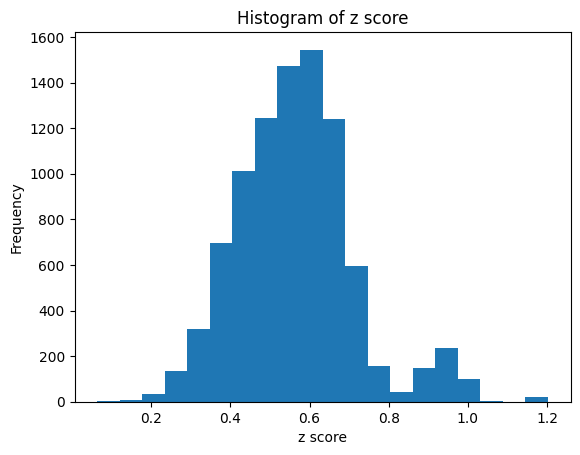

In [80]:
### Plot histogram of df_results['z']
plt.hist(df_results['z'], bins=20)
plt.xlabel('z score')
plt.ylabel('Frequency')
plt.title('Histogram of z score')
plt.show()

In [81]:
df_results['z'].describe()

count    8998.000000
mean        0.563851
std         0.148890
min         0.062977
25%         0.464368
50%         0.559884
75%         0.643760
max         1.202347
Name: z, dtype: float64

In [82]:
df.describe()

,333615,332041,343220,328559,329741,329385,334269,332584,344418,331224,...,330399,331209,328168,335242,344419,341317,335083,341540,332615,332386
count,8998.000000,8998.000000,8998.000000,8998.00000,8998.000000,8998.000000,8998.000000,8998.000000,8998.000000,8998.000000,...,8998.000000,8998.000000,8998.000000,8998.000000,8998.000000,8998.00000,8998.000000,8998.000000,8998.000000,8998.000000
mean,0.047233,0.033341,0.044454,0.04990,0.047122,0.047122,0.050011,0.047010,0.044454,0.047233,...,0.022227,0.013892,0.016559,0.013892,0.019449,0.01667,0.022227,0.019449,0.022116,0.022227
std,0.212148,0.179535,0.206114,0.21775,0.211911,0.211911,0.217980,0.211673,0.206114,0.212148,...,0.147430,0.117049,0.127620,0.117049,0.138104,0.12804,0.147430,0.138104,0.147069,0.147430
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [83]:
import prim

# Perform Prim Analysis on df_results and df based on maximizing critical (hours)

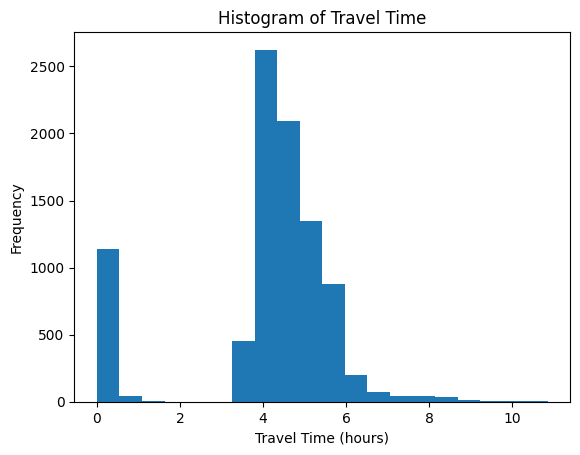

In [84]:
### plot histogram of df_results['hours']
plt.hist(df_results['hours'], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Travel Time')
plt.show()


# TODO: Establish automated way to identify otimum threshold for the PRIM analysis
- start with mean
- perform prim and measure number of inputs 
- iterate through increasing thershold values
- determine the threshold with the largest number of inputs for scenario discovery

In [85]:
### get the index values of df_results.loc[lp_evac_idx]['hours] that are greater than 4
#mask = df_results.loc[lp_evac_idx]['hours'] > 4
### get the index of df_results where df_results['hours'] > 4
critical_fleet_results_idx = df_results[df_results['hours'] > 4].index

### describe df_results.loc[critical_fleet_results_idx]
df_results.loc[critical_fleet_results_idx].describe()
critical_results_describe = df_results.loc[critical_fleet_results_idx].describe().to_dict()
np.floor(critical_results_describe['hours']['mean'])

4.0

In [86]:
setMean = critical_results_describe['hours']['mean']
setMax = critical_results_describe['hours']['max']

crit_boxes = []

### create 10 threshold values from setMean to setMax in increments of 0.5
thresholds = []
differ_increment = (setMax - setMean)/10
for i in range(10):
    if i == 0:
        thresholds.append(setMean)
    else:
        thresholds.append(thresholds[i-1] + differ_increment)

maxThreshold = 0
maxCount = 0
critIndex = 0
### create a loop to iterate from setMean to setMax in increments of 0.5
for t in thresholds:        
    prim_alg = prim.Prim(df.loc[critical_fleet_results_idx], df_results.loc[critical_fleet_results_idx]['hours'], threshold=t, threshold_type='>')
    try:
        crit_box = prim_alg.find_all()
        #print(len(crit_box))

        crit_boxes.append(crit_box)
        
        ### get list of all index values for each crit_box
        crit_ids = []
        for i in range(len(crit_box)):
            print(list(crit_box[i].limits.index))
            ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
            for j in list(crit_box[i].limits.index):
                if j not in crit_ids:
                    crit_ids.append(j)

        ### print the number of unique index values in crit_ids
        if len(set(crit_ids)) >= maxCount:
            maxCount = len(set(crit_ids))
            maxThreshold = t
            critIndex = thresholds.index(t)
        print('Number of unique index values in crit_ids: ', t, len(set(crit_ids)))
    except:
        print("zero boxes")
        print('Number of unique index values in crit_ids: ', t, len(set(crit_ids)))

[]
Number of unique index values in crit_ids:  4.883307202848992 0
[]
Number of unique index values in crit_ids:  5.480686760341871 0
[]
Number of unique index values in crit_ids:  6.078066317834749 0
[]
Number of unique index values in crit_ids:  6.675445875327628 0
[]
Number of unique index values in crit_ids:  7.272825432820507 0
[]
Number of unique index values in crit_ids:  7.870204990313385 0
[]
Number of unique index values in crit_ids:  8.467584547806263 0
[]
Number of unique index values in crit_ids:  9.064964105299142 0
[]
Number of unique index values in crit_ids:  9.66234366279202 0
[]
Number of unique index values in crit_ids:  10.259723220284899 0


In [540]:
print('Max Count: ', maxCount)
print('Max Threshold: ', maxThreshold)
crit_boxes[critIndex][0].limits

crit_ids = []
for i in range(len(crit_boxes[critIndex])):
    print(list(crit_boxes[critIndex][i].limits.index))
    ### add crit_box[i].limits.index to crit_ids but only if it is not already in crit_ids
    for j in list(crit_boxes[critIndex][i].limits.index):
        if j not in crit_ids:
            crit_ids.append(j)

Max Count:  9
Max Threshold:  6.858030522826883
['334420', '330512', '329644', '329502', '330221']
['329644', '329940', '330221']
['329644', '329502', '330221']
['335090', '328862']
['329644', '329091']
[]


# Perform Prim Analysis on df_results and df based on maximizing z


In [541]:
df_results['z'].describe()

count    3980.000000
mean        0.617195
std         0.241593
min         0.072978
25%         0.380519
50%         0.738599
75%         0.831922
max         1.193958
Name: z, dtype: float64

In [542]:
### Get the index of rows in df_results['z'] that are greater than 0.1
idx = df_results[df_results['z'] > 0.75].index
### print the rows of df where the index is in idx
#df.loc[idx].describe()
df_results.loc[idx]['z'].describe()
CSI_results_describe = df_results.loc[idx]['z'].describe().to_dict()
print(CSI_results_describe['mean'])

0.8434588690717761


In [543]:
setMean = CSI_results_describe['mean']
setMax = CSI_results_describe['max']

csi_boxes = []

### create 10 threshold values from setMean to setMax in increments of 0.5
thresholds = []
differ_increment = (setMax - setMean)/10
for i in range(10):
    if i == 0:
        thresholds.append(setMean)
    else:
        thresholds.append(thresholds[i-1] + differ_increment)

maxThreshold = 0
maxCount = 0
csi_index = 0
### create a loop to iterate from setMean to setMax in increments of 0.5
for t in thresholds: 
    prim_alg = prim.Prim(df.loc[idx], df_results.loc[idx]['z'], threshold=t, threshold_type='>')
    try:
        CSI_box = prim_alg.find_all()
        #print(len(CSI_box))
        csi_boxes.append(CSI_box)

        csi_ids = []
        for i in range(len(CSI_box)):
            print(list(CSI_box[i].limits.index))
            ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
            for j in list(CSI_box[i].limits.index):            
                if j not in csi_ids:
                    csi_ids.append(j)
        ### print the number of unique index values in csi_ids
        if len(csi_ids) >= maxCount:
            maxCount = len(csi_ids)
            maxThreshold = t
            ### set csi_index to the index of t in thresholds
            csiIndex = thresholds.index(t)
        print('Number of unique index values in csi_ids: ', t, len(set(csi_ids)))
    except:
        print("found zero boxes")
        print('Number of unique index values in csi_ids: ', t, len(set(csi_ids)))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['335360']
[]
Number of unique index values in csi_ids:  0.8434588690717761 1


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['329174', '341121', '334931', '330221', '334722', '329105']
['330512', '332329', '329644', '334931', '330221', '329105']
['328156', '334931', '330221', '334722', '329105']
['330512', '334931', '330221', '329105']
['335525', '338651', '334250']
['332329', '336216', '329821', '335360', '332253']
['331775', '330221']
['341121', '334722', '341295']
['330512', '332329']
[]
Number of unique index values in csi_ids:  0.8785088080891481 19


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '329502', '336066', '335360', '330221']
['332329', '334931', '331750', '330221', '334722', '341386']
['330512', '329644', '330221']
['330512', '329174', '330184', '329821']
['338651', '330221', '334722']
['332329', '330221']
[]
Number of unique index values in csi_ids:  0.9135587471065201 15


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '343703', '329502', '336276', '330221']
['329174', '336153', '341121', '333480']
['330512', '329644', '330221']
['330512', '330221']
[]
Number of unique index values in csi_ids:  0.948608686123892 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '343703', '329502', '336276', '330221']
['329174', '336153', '341386', '333480']
[]
Number of unique index values in csi_ids:  0.983658625141264 10


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '343703', '329502', '336276', '330221']
[]
Number of unique index values in csi_ids:  1.018708564158636 6


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '329502', '330221']
[]
Number of unique index values in csi_ids:  1.053758503176008 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329644', '329502', '330221']
[]
Number of unique index values in csi_ids:  1.08880844219338 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


['330512', '329502', '330221', '334722']
[]
Number of unique index values in csi_ids:  1.1238583812107519 4
['330512', '329502', '341121', '332253']
[]
Number of unique index values in csi_ids:  1.1589083202281238 4


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [544]:
print('Max Count: ', maxCount)
print('Max Threshold: ', maxThreshold)
csi_boxes[csiIndex][1].limits

csi_ids = []
for i in range(len(csi_boxes[csiIndex])):
    print(list(csi_boxes[csiIndex][i].limits.index))
    ### add CSI_box[i].limits.index to csi_ids but only if it is not already in csi_ids
    for j in list(csi_boxes[csiIndex][i].limits.index):
        if j not in csi_ids:
            csi_ids.append(j)

Max Count:  19
Max Threshold:  0.8785088080891481
['329174', '341121', '334931', '330221', '334722', '329105']
['330512', '332329', '329644', '334931', '330221', '329105']
['328156', '334931', '330221', '334722', '329105']
['330512', '334931', '330221', '329105']
['335525', '338651', '334250']
['332329', '336216', '329821', '335360', '332253']
['331775', '330221']
['341121', '334722', '341295']
['330512', '332329']
[]


# Generate KML for crit_box and CSI_box IDs


In [545]:
if 'fleet' in dbFile:
    print(fleet_lat_long_dict[int(crit_ids[0])])
else:
    print(ladris_latlong_dict[int(crit_ids[0])])
    print(ladris_segment_roadNames[int(crit_ids[0])])

[[-121.1323993, 39.1644618], [-121.1324019, 39.1644117], [-121.1324066, 39.1643185], [-121.1314762, 39.1632896], [-121.1314409, 39.1629635], [-121.1316671, 39.162649], [-121.1324963, 39.1618332], [-121.1327205, 39.1615423], [-121.1327307, 39.1615155], [-121.1327857, 39.1613709], [-121.1328344, 39.1612429], [-121.1332105, 39.1602543], [-121.1333773, 39.159969], [-121.1343037, 39.15924]]
McCourtney Road


In [546]:
import ast
from geopandas import GeoDataFrame
import geopandas as gpd
from shapely.geometry import LineString


In [547]:
if 'fleet' in dbFile:
    #### update fleet_lat_long_dict to be a dictionary of linestrings
    for i in fleet_lat_long_dict:
        fleet_lat_long_dict[i] = LineString([ast.literal_eval(str(fleet_lat_long_dict[i][0])), ast.literal_eval(str(fleet_lat_long_dict[i][1]))])
else:
    ### update ladris_latlong_dict to be a dictionary of linestrings
    for i in ladris_latlong_dict:
        ladris_latlong_dict[i] = LineString([ast.literal_eval(str(ladris_latlong_dict[i][0])), ast.literal_eval(str(ladris_latlong_dict[i][1]))])


In [548]:
if 'fleet' in dbFile:
    #all_gdf = GeoDataFrame(geometry=[fleet_lat_long_dict[i] for i in fleet_lat_long_dict])
    all_gdf = GeoDataFrame(
        {"id": list(fleet_lat_long_dict.keys()), "geometry": list(fleet_lat_long_dict.values())}
    )

    crit_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in crit_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in crit_ids]}
    )

    csi_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in csi_ids], "geometry": [fleet_lat_long_dict[int(i)] for i in csi_ids]}
    )
else:
    all_gdf = GeoDataFrame(
        {"id": list(ladris_latlong_dict.keys()), "geometry": list(ladris_latlong_dict.values())}
    )

    crit_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in crit_ids], "geometry": [ladris_latlong_dict[int(i)] for i in crit_ids]}
    )

    csi_sub_gdf = GeoDataFrame(
        {"id": [int(i) for i in csi_ids], "geometry": [ladris_latlong_dict[int(i)] for i in csi_ids]}
    )


In [549]:
import datetime
now = datetime.datetime.now()
if 'fleet' in dbFile:
    crit_fname = 'fleet_crit_segments_'+str(now.date())+'.kml'
    csi_fname = 'fleet_csi_segments_'+str(now.date())+'.kml'
    ### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
    crit_sub_gdf.to_file(crit_fname, driver='KML', index=False)
    csi_sub_gdf.to_file(csi_fname, driver='KML', index=False)
else:
    ### output geodataframe sub_gdf to kml file where id is the identity label and geometry is the lat long for position of the segment
    crit_fname = 'ladris_crit_segments_'+str(now.date())+'.kml'
    csi_fname = 'ladris_csi_segments_'+str(now.date())+'.kml'
    crit_sub_gdf.to_file(crit_fname, driver='KML', index=False)
    csi_sub_gdf.to_file(csi_fname, driver='KML', index=False)




/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Layer name 'ladris_crit_segments_2025-06-04' adjusted to 'ladris_crit_segments_2025_06_04' for XML validity.
  ogr_write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(
/home/pfoytik/anaconda3/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: Layer name 'ladris_csi_segments_2025-06-04' adjusted to 'ladris_csi_segments_2025_06_04' for XML validity.
  ogr_write(


In [550]:
str(now.date())

'2025-06-04'

# Compare evac time for scenarios of CRIT and scenarios of CSI

In [551]:
print(len(crit_boxes[critIndex]), len(csi_boxes[critIndex]))


6 5


In [552]:
import prim as prim
import numpy as np


In [553]:
def getCriticalTimes(df, crit_box):
    criticalTimes = {}
    for c in range(len(crit_box)):
        ctime = []
        tempDict = {}

        ## the list of column names
        #list(crit_box[0].limits.index))

        ### the list of values
        #list(crit_box[0].limits['min'])
        cb_index = list(crit_box[c].limits.index)
        
        ### convert cb_index to integers
        if 'fleet' not in dbFile:
            for i in range(len(cb_index)):
                if isinstance(cb_index[i], str):
                    cb_index[i] = int(cb_index[i])

        ### create dictionary of list(crit_box[0].limits.index) and list(crit_box[0].limits['min'])
        for i in range(len(cb_index)):
            tempDict[cb_index[i]] = list(crit_box[c].limits['min'])[i]

        if len(tempDict) > 2:
            ### convert tempDict values to integers
            for i in tempDict:
                if isinstance(tempDict[i], str):
                    tempDict[i] = int(tempDict[i])
                else:
                    tempDict[i] = int(tempDict[i])
            #print(tempDict.values())

            ### get the index of df[list(crit_box[1].limits.index)] where the values are equal to tempDict.values()
            cb1_idx = list(df[cb_index].index)

            ### for each row of df[list(crit_box[1].limits.index)].values.tolist() compare the list to tempDict.values()
            count = 0
            for i in df[cb_index].values.tolist():
                if i == list(tempDict.values()):
                    #print(cb1_idx[count], i)
                    ctime.append(df_results.loc[cb1_idx[count]]['hours'])
                count += 1
            criticalTimes[c] = ctime
            print(round(np.mean(ctime), 2), round(np.max(ctime), 2), round(np.min(ctime), 2), len(ctime))
    return criticalTimes

# Results for Fleet 0.75 lam1, 1 lam2
### All Data
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 3.49 | 8.33 | 2.67 | 3896  |

### Critical
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 4.42 | 7.42 | 2.67 | 281   |
| 4.74 | 6.5  | 3.67 | 108   |
| 5.1  | 6.5  | 2.67 | 117   |
| 3.98 | 7.42 | 2.67 | 521   |
| 5.11 | 8.33 | 2.67 | 262   |
| 4.1  | 8.33 | 2.67 | 746   |

### CSI
| Mean | Max  | Min  | Count |
|------|------|------|-------|
| 4.97 | 5.5  | 3.58 | 148   |
| 3.78 | 8.33 | 2.67 | 242   |
| 3.19 | 5.5  | 2.67 | 481   |

# Results for Ladris 0.5 lam1, 1 lam2
- Reducing the crit lam1 to 0.1 reduced the mean eavacuation time of the CSI scenarios by 1 hour!
- increaseing the crit lam1 to 1 increases the mean evacuation time of the CSI scenarios by 1 hours!
  - doing this reduces several areas of surprise in particular the segments on lower colfax rd.
### All Data
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 4.62 | 10.64 | 3.62 | 3980  |

### Critical
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 8.04 | 10.55 | 5.17 | 114   |
| 6.56 | 10.64 | 4.13 | 242   |
| 6.23 | 10.55 | 4.11 | 508   |

### CSI
| Mean | Max   | Min  | Count |
|------|-------|------|-------|
| 5.63 | 10.51 | 4.19 | 175   |
| 6.44 | 10.51 | 4.45 | 145   |
| 5.58 | 10.29 | 4.19 | 317   |
| 5.62 | 10.51 | 3.95 | 605   |
| 4.52 | 10.21 | 3.65 | 503   |
| 4.38 | 9.46  | 3.65 | 321   |
| 4.33 | 8.38  | 3.67 | 494   |


In [554]:
len(crit_boxes[critIndex])

6

In [555]:
### get critical times for each crit_box
criticalTimes = getCriticalTimes(df, crit_boxes[critIndex])
#print(criticalTimes)
print("<><><><><><><><><><><><><><><><><>")
csiTimes = getCriticalTimes(df, csi_boxes[csiIndex])
print(len(criticalTimes), len(csiTimes))

/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


8.04 10.55 5.17 114
6.56 10.64 4.13 242
6.23 10.55 4.11 508
<><><><><><><><><><><><><><><><><>
5.63 10.51 4.19 175
6.44 10.51 4.45 145
5.58 10.29 4.19 317
5.62 10.51 3.95 605


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


4.52 10.21 3.65 503
4.38 9.46 3.65 321
4.33 8.38 3.67 494
3 7


/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj
/home/pfoytik/anaconda3/lib/python3.10/site-packages/prim/prim_box.py:783: RuntimeWarning: invalid value encountered in scalar divide
  p = Hj/Tj


In [556]:
df_results['hours'].describe()

count    3980.000000
mean        4.621546
std         1.209052
min         3.624039
25%         3.793138
50%         4.140205
75%         5.171863
max        10.639947
Name: hours, dtype: float64

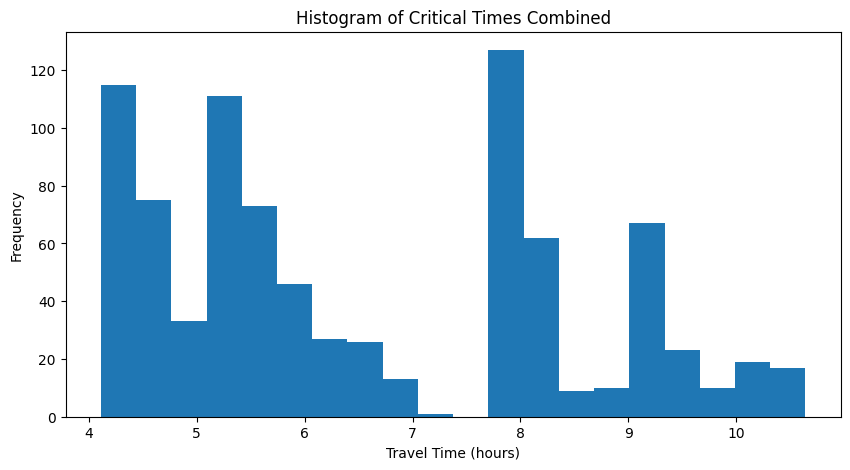

In [557]:
### create a histogram of the critical times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in criticalTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Critical Times Combined')
plt.show()

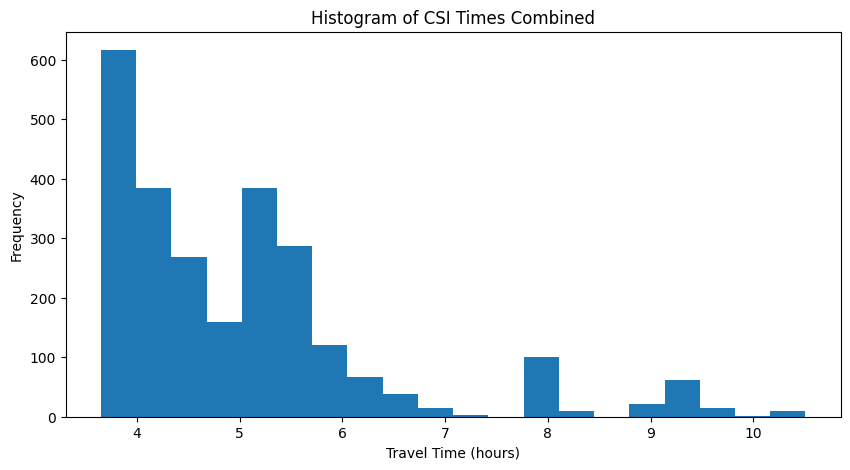

In [558]:
### create a histogram of csi times combined
plt.figure(figsize=(10, 5))
plt.hist([item for sublist in csiTimes.values() for item in sublist], bins=20)
plt.xlabel('Travel Time (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of CSI Times Combined')
plt.show()

In [567]:
### check the segment IDs in criticalTimes and csiTimes and print the road name
segz = crit_boxes[csiIndex][1].limits.index
for s in segz:
    if 'fleet' in dbFile:
        print(s, fleet_segment_roadNames[int(s)], criticalTimes[0])
    else:
        if 'Colfax' in ladris_segment_roadNames[int(s)]:
            print(s, ladris_segment_roadNames[int(s)], criticalTimes[0])

329940 Colfax Highway [5.837976666666666, 10.339149083333334, 8.353910611111111, 7.941659777777778, 5.541368666666667, 10.506315916666669, 9.159998888888888, 8.083556805555554, 5.576642888888888, 8.381494277777778, 9.554956222222222, 9.251831944444444, 5.183307222222222, 7.878779166666666, 5.6916224444444445, 8.958286333333332, 8.056443500000002, 8.04355475, 7.9849230833333324, 10.236361333333331, 5.174888194444445, 10.08854277777778, 9.1483055, 9.733348166666666, 8.105839583333333, 10.20699, 8.001647, 6.136309388888889, 7.829692805555556, 8.014229222222223, 8.022224999999999, 8.361721249999999, 5.20959211111111, 10.55172525, 9.052595, 8.010688055555555, 5.288685972222223, 8.0214225, 7.94720388888889, 9.135502277777778, 5.363711388888889, 7.794951833333333, 7.962676666666666, 7.854442055555555, 8.060518472222222, 5.329385888888889, 8.09984888888889, 7.992330777777778, 10.07100977777778, 8.090518611111111, 8.1148725, 7.915405527777778, 7.948755166666667, 8.02120611111111, 10.32501625, 8

In [562]:
ladris_segment_roadNames[329174]
#ladris_latlong_dict[329174]

'Rattlesnake Road'